In [1]:
import os
os.chdir(os.getcwd()[:-6])

In [8]:
from float.data import DataLoader
from float.prediction.skmultiflow import SkmultiflowClassifier
from float.prediction.evaluation import PredictionEvaluator
from float.pipeline import PrequentialPipeline
from skmultiflow.trees import HoeffdingTreeClassifier
from skmultiflow.neural_networks.perceptron import PerceptronMask
from skmultiflow.drift_detection.adwin import ADWIN
from sklearn.metrics import zero_one_loss
from float.visualization import plot, spider_chart, concept_drifts_scatter
from float.prediction.evaluation.measures import noise_variability, mean_drift_performance_deterioration
from float.change_detection import ERICS
from float.change_detection.skmultiflow import SkmultiflowChangeDetector
from float.change_detection.evaluation import ChangeDetectionEvaluator
from float.change_detection.evaluation.measures import mean_time_ratio
import matplotlib.pyplot as plt

In [3]:
data_loader = DataLoader(None, f'float/data/datasets/spambase.csv', target_col=0)

known_drifts = [round(data_loader.stream.n_samples * 0.2), round(data_loader.stream.n_samples * 0.4),
                round(data_loader.stream.n_samples * 0.6), round(data_loader.stream.n_samples * 0.8)]

predictor = SkmultiflowClassifier(HoeffdingTreeClassifier(), data_loader.stream.target_values, reset_after_drift=True)
pred_evaluator = PredictionEvaluator([zero_one_loss], decay_rate=0.1, window_size=10)

change_detectors = [SkmultiflowChangeDetector(ADWIN(delta=0.6), reset_after_drift=False),
                           ERICS(data_loader.stream.n_features)]
cd_evaluators = [ChangeDetectionEvaluator(measure_funcs=[mean_time_ratio],
                                        known_drifts=known_drifts,
                                        batch_size=10,
                                        n_samples=data_loader.stream.n_samples,
                                        n_delay=list(range(100, 1000)),
                                        n_init_tolerance=100)
               for i in range(2)]
for i in range(2):
    prequential_pipeline = prequential_pipeline = PrequentialPipeline(data_loader=data_loader,
                                               change_detector=change_detectors[i],
                                               change_detection_evaluator=cd_evaluators[i],
                                               predictor=predictor,
                                               prediction_evaluator=pred_evaluator,
                                               batch_size=10,
                                               max_n_samples=data_loader.stream.n_samples - 10,
                                               known_drifts=known_drifts,)
    prequential_pipeline.run()

Pretrain predictor with 100 observation(s).
[====================] 100%
################################## SUMMARY ##################################
Evaluation finished after 19.153347492218018s
Data Set float/data/datasets/spambase.csv
Processed 4591 instances in batches of 10
----------------------
Concept Drift Detection:
| Model   |   Avg. Time | Detected Global Drifts   |   Avg. mean_time_ratio |
|---------|-------------|--------------------------|------------------------|
| ADWIN   | 0.000631074 | []                       |                      0 |
----------------------
Prediction:
| Model                 |   Avg. Test Time |   Avg. Train Time | Avg. zero_one_loss                                                                                                                                                                                                                                                                                                                                

[                    ] 2%Global change detected at time step 2
[                    ] 3%Global change detected at time step 4
[                    ] 3%Global change detected at time step 6
[                    ] 3%Global change detected at time step 8
[                    ] 4%Global change detected at time step 10
[                    ] 4%Global change detected at time step 12
[=                   ] 5%Global change detected at time step 14
[=                   ] 5%Global change detected at time step 16
[=                   ] 6%Global change detected at time step 18
[=                   ] 6%Global change detected at time step 20
[=                   ] 6%Global change detected at time step 22
[=                   ] 7%Global change detected at time step 24
[=                   ] 7%Global change detected at time step 26
[=                   ] 8%Global change detected at time step 28
[=                   ] 8%Global change detected at time step 30
[=                   ] 9%Global change detec

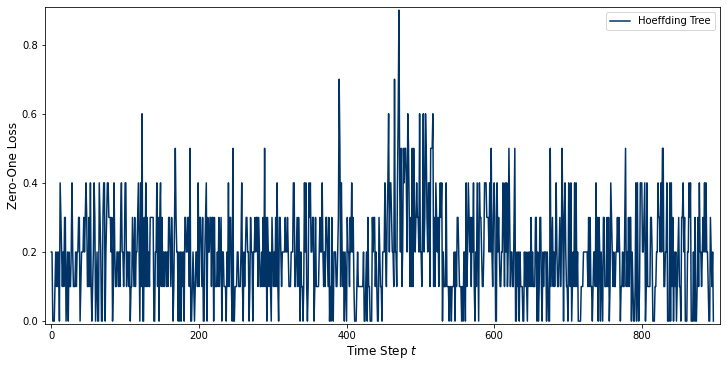

In [4]:
plot(measures=[pred_evaluator.result['zero_one_loss']['measures']],
     labels=['Hoeffding Tree'],
     measure_name='Zero-One Loss',
     measure_type='prediction',
     smooth_curve=[False])
plt.show()

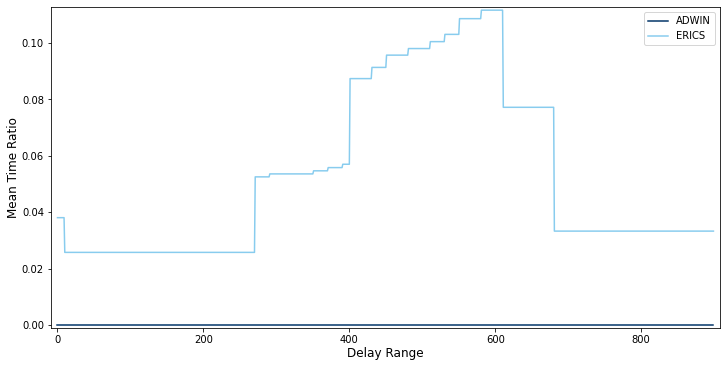

In [6]:
plot(measures=[cd_evaluators[0].result['mean_time_ratio']['measures'], cd_evaluators[1].result['mean_time_ratio']['measures']],
     labels=['ADWIN', 'ERICS'],
     measure_name='Mean Time Ratio',
     measure_type='change_detection')
plt.show()

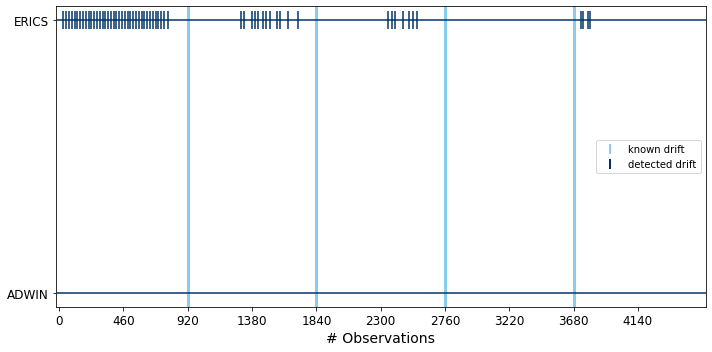

In [10]:
concept_drifts_scatter(measures=[change_detectors[0].drifts, change_detectors[1].drifts],
                       labels=['ADWIN', 'ERICS'],
                       measure_type='change_detection',
                       data_stream=data_loader.stream,
                       known_drifts=known_drifts,
                       batch_size=10)
plt.show()